In [1]:
import shap
import random

import pandas as pd
import numpy as np

import dr_explainer as dre

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

C:\Users\wilso\Anaconda3\envs\ia-tools\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\wilso\Anaconda3\envs\ia-tools\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\wilso\Anaconda3\envs\ia-tools\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\wilso\Anaconda3\envs\ia-tools\lib\site-packages\tensorf

In [2]:
data = load_iris()
X, y = data.data, data.target

### Project the dataset

In [3]:
import umap

reducer = umap.UMAP(verbose=0, random_state=0)
embedding = reducer.fit_transform(X)

Embedding a total of 2 separate connected components using meta-embedding (experimental)


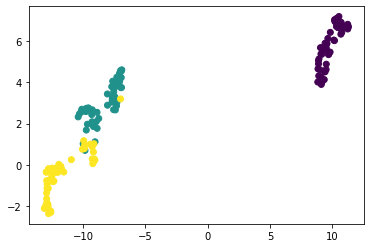

In [4]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)

### Generate explanations for the ground truth classes

In [5]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, y)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


### Compute explanations for a few samples

In [6]:
to_explain = np.array(random.sample(X.tolist(), int(X.shape[0] * 0.2)))

shap_values = clusterShapley.transform(to_explain)

In [7]:
shap_values.shape

(3, 30, 4)

##### The matrix shap_values contains: 
* the feature contributions for each cluster/class (3);
* upon the samples used to generate explanations (30);
* for each feature (4).

### Visualize the contributions using SHAP plots

For now, you can rely on SHAP library to visualize the contributions

In [8]:
### create an Explanation for the class of interest

klass = 0

c_exp = shap.Explanation(shap_values[klass], data=to_explain, feature_names=data.feature_names)

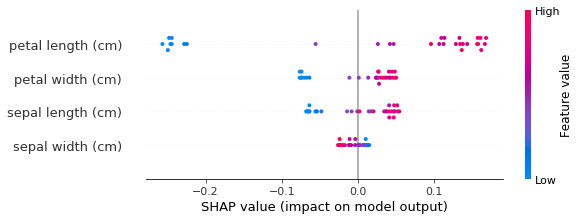

In [9]:
shap.plots.beeswarm(c_exp)

### How to interpret?

The plot shows the contributions of each feature for cluster/class cohesion for the selected cluster/class.

Example for 'petal length (cm)':

* Low feature values (blue) contribute for the cohesion of the selected class/cluster.
* Higher feature values (red) **do not** contribute for the cohesion.

### Defining your own clusters

Suppose you want to investigate why UMAP cluster 2 classes together while projecting the third one distant in 2D.

To investigate that, we can use ClusterShapley to explain how the features contribute to these **two** major clusters.

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(embedding)

indices = np.arange(embedding.shape[0])

indices_0 = indices[kmeans.labels_ == 0]
indices_1 = indices[kmeans.labels_ == 1]

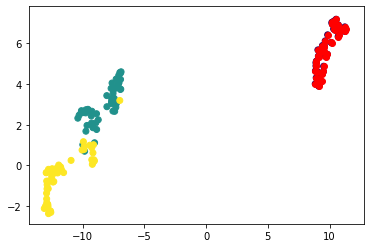

In [11]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
plt.scatter(embedding[indices_0, 0], embedding[indices_0, 1], c='red')

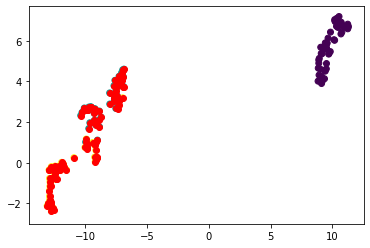

In [12]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
plt.scatter(embedding[indices_1, 0], embedding[indices_1, 1], c='red')

So, 

* we have **cluster 0** as the cluster on **right**;
* we have **cluster 1** as the cluster on **left**.

Lets generate explanations for these two clusters **upon** UMAP projection.

In [13]:
clusterShapley = dre.ClusterShapley()
clusterShapley.fit(X, kmeans.labels_)

Preprocessing data...
Creating summary of the background dataset...
Computing explanations...


In [14]:
shap_values = clusterShapley.transform(to_explain)

###### Right cluster 

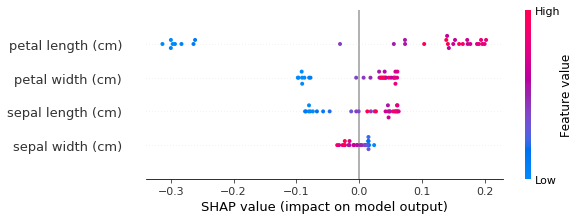

In [15]:
c_exp = shap.Explanation(shap_values[0], data=to_explain, feature_names=data.feature_names)
shap.plots.beeswarm(c_exp)

This cluster is characterized by the low values of *petal length (cm)*, *petal width (cm)*, *sepal length (cm)*.

##### Left cluster

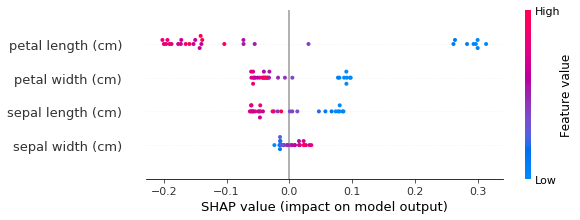

In [16]:
c_exp = shap.Explanation(shap_values[1], data=to_explain, feature_names=data.feature_names)
shap.plots.beeswarm(c_exp)

On the other hand, the left cluster (composed by two classes) is characterized by high values of *petal length (cm)*, *petal width (cm)*, *sepal length (cm)*.